In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
if os.getcwd() != '/content/drive/My Drive':
    os.chdir('./drive/My Drive')

Mounted at /content/drive/


In [ ]:
!pwd

/content/drive/My Drive


In [4]:
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 transform
from torch.utils.data import DataLoader # 이미지 데이터 로더
import os
import glob

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
train_path = 'C:/Users/drago/Tank_data/train'
test_path = 'C:/Users/drago/Tank_data/test'

Challenger2_dir = '/Challenger2/'
K2_dir = '/K2/'
Leopard2_dir = '/Leopard2/'

In [6]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)), # 이미지 resize
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

trainset = torchvision.datasets.ImageFolder(root=train_path, transform=transform_train)
testset = torchvision.datasets.ImageFolder(root=test_path, transform=transform_test)

In [7]:
#batchSize
batchSize=32

In [8]:
#dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=0)

In [9]:
print(trainset[0][0].shape)
print(trainset[0][0])

torch.Size([3, 256, 256])
tensor([[[0.7686, 0.7725, 0.7569,  ..., 0.6471, 0.6157, 0.5922],
         [0.7725, 0.7490, 0.7059,  ..., 0.6471, 0.6157, 0.5961],
         [0.6824, 0.6392, 0.5804,  ..., 0.6431, 0.6157, 0.6000],
         ...,
         [0.2039, 0.2000, 0.1961,  ..., 0.4549, 0.3882, 0.3098],
         [0.1922, 0.1882, 0.1804,  ..., 0.4980, 0.4078, 0.3216],
         [0.0627, 0.0588, 0.0510,  ..., 0.5059, 0.4078, 0.3490]],

        [[0.6392, 0.6431, 0.6275,  ..., 0.4824, 0.4745, 0.4627],
         [0.6431, 0.6196, 0.5765,  ..., 0.4863, 0.4784, 0.4667],
         [0.5529, 0.5098, 0.4471,  ..., 0.4824, 0.4784, 0.4745],
         ...,
         [0.3490, 0.3451, 0.3412,  ..., 0.5961, 0.5294, 0.4510],
         [0.2941, 0.2902, 0.2824,  ..., 0.6431, 0.5529, 0.4706],
         [0.1294, 0.1255, 0.1176,  ..., 0.6510, 0.5608, 0.5020]],

        [[0.4314, 0.4431, 0.4275,  ..., 0.1843, 0.1686, 0.1529],
         [0.4431, 0.4196, 0.3765,  ..., 0.1765, 0.1608, 0.1490],
         [0.3529, 0.3098, 0.2588

In [10]:
import math
import torch
import torch.utils.model_zoo as model_zoo
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

class Bottleneck(nn.Module):
    '''
    ResNet Bottleneck
    - 입력 : in_planes(입력 채널 수), out_planes(출력 채널 수), stride, dilation, downsample
    - 출력 : Bottleneck 객체
    - Convolution - BatchNorm - ReLU 3번을 하면서 Bottleneck 구조와 skip connection을 만든다. 필요 시 downsample도 수행함
    '''
    expansion = 4
    def __init__(self, in_planes, out_planes, stride=1, dilation=1,
                 downsample=None):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)

        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=stride,padding=dilation, dilation=dilation, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

        self.conv3 = nn.Conv2d(out_planes, out_planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes * 4)

        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample

        self.dilation = dilation
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class FPN(nn.Module):
    """Dilated Pre-trained ResNet Model, which reduces the stride of 8 featuremaps at conv5.
    Parameters
    ----------
    - block : BasicBlock 또는 Bottleneck
        - Residual Block의 타입을 정합니다.
        - 타입은 BasicBlock 또는 Bottleneck으로 위에 선언한 클래스에 해당합니다.
    layers : int 값을 가지는 list
        - 각각의 block에서의 layer 수를 입력
    classes : int, 기본값은 1000
        - classification 할 class의 갯수
    dilated : bool, 기본값은 True
        - Dilated Convolution을 적용 할 지에 대한 Bool 값
    """

    def __init__(self, block, layers, num_classes=1000, dilated=True):
        self.in_planes = 32
        super(FPN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 32, layers[0])
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2)

        if dilated:
            self.layer3 = self._make_layer(block, 128, layers[2], stride=2, dilation=2)
            self.layer4 = self._make_layer(block, 256, layers[3], stride=2)# , dilation=4)
        else:
            self.layer3 = self._make_layer(block, 128, layers[2], stride=2)
            self.layer4 = self._make_layer(block, 256, layers[3], stride=2)

        self.toplayer = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)  # #output channel -> 256,

        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        #다 256 채널 깊이로 만들어줌 , 1x1 conv
        # Lateral layers
        self.latlayer1 = nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)

        self.re_Bottom_up_layer = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)


    def _make_layer(self, block, planes, blocks, stride=1, dilation=1):
        downsample = None

        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        if dilation == 1:
            layers.append(block(self.in_planes, planes, stride, dilation=1, downsample=downsample))
        elif dilation == 2:
            layers.append(block(self.in_planes, planes, stride, dilation=dilation, downsample=downsample))

        """
        elif dilation == 4:
            layers.append(block(self.in_planes, planes, stride, dilation=dilation, downsample=downsample))

        else:
            raise RuntimeError("=> unknown dilation size: {}".format(dilation))
        """

        self.in_planes = planes * block.expansion

        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes, dilation=dilation))

        return nn.Sequential(*layers)

    def _upsample_add(self, x, y):
        '''Upsample and add two feature maps.

        Args:
          x: (Variable) top feature map to be upsampled.
          y: (Variable) lateral feature map.

        Returns:
          (Variable) added feature map.

        Note in PyTorch, when input size is odd, the upsampled feature map
        with `F.upsample(..., scale_factor=2, mode='nearest')`
        maybe not equal to the lateral feature map size.

        e.g.
        original input size: [N,_,15,15] ->
        conv2d feature map size: [N,_,8,8] ->
        upsampled feature map size: [N,_,16,16]

        So we choose bilinear upsample which supports arbitrary output sizes.
        '''
        _,_,H,W = y.size()
        return F.upsample(x, size=(H,W), mode='bilinear') + y

    def forward(self, x):
        # Bottom-up
        c1 = F.relu(self.bn1(self.conv1(x)))
        c1 = F.max_pool2d(c1, kernel_size=3, stride=2, padding=1)
        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)
        # Top-down
        p5 = self.toplayer(c5) #top layer 1by1 conv
        p4 = self._upsample_add(p5, self.latlayer1(c4)) #채널 조정해준 뒤 upsampling 두번째 위에꺼 그리고 merge
        p3 = self._upsample_add(p4, self.latlayer2(c3)) #채널 조정해준 뒤 upsampling 세번째 위에꺼 그리고 merge
        p2 = self._upsample_add(p3, self.latlayer3(c2)) #채널 조정해준 뒤 upsampling 맨 밑에꺼 그리고 merge
        # Smooth

        p4 = self.smooth1(p4)
        p3 = self.smooth2(p3)
        p2 = self.smooth3(p2)

        x=self.re_Bottom_up_layer(p2)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)

        return x

def FPN_Net():
    return FPN(Bottleneck, [3,4,6,3],3).to(device)

In [11]:
model =FPN_Net()

In [12]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256), device=device)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            4,704
├─BatchNorm2d: 1-2                       64
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  1,024
|    |    └─BatchNorm2d: 3-2             64
|    |    └─Conv2d: 3-3                  9,216
|    |    └─BatchNorm2d: 3-4             64
|    |    └─Conv2d: 3-5                  4,096
|    |    └─BatchNorm2d: 3-6             256
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              4,352
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  4,096
|    |    └─BatchNorm2d: 3-10            64
|    |    └─Conv2d: 3-11                 9,216
|    |    └─BatchNorm2d: 3-12            64
|    |    └─Conv2d: 3-13                 4,096
|    |    └─BatchNorm2d: 3-14            256
|

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            4,704
├─BatchNorm2d: 1-2                       64
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  1,024
|    |    └─BatchNorm2d: 3-2             64
|    |    └─Conv2d: 3-3                  9,216
|    |    └─BatchNorm2d: 3-4             64
|    |    └─Conv2d: 3-5                  4,096
|    |    └─BatchNorm2d: 3-6             256
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              4,352
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  4,096
|    |    └─BatchNorm2d: 3-10            64
|    |    └─Conv2d: 3-11                 9,216
|    |    └─BatchNorm2d: 3-12            64
|    |    └─Conv2d: 3-13                 4,096
|    |    └─BatchNorm2d: 3-14            256
|

In [13]:
import torch.optim as optim

"""
lr = 0.0008

optimizer = 'Adam'
"""

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [14]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [15]:
epochs = 100

In [16]:
train_loss=[]
test_accuracy=[]

for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0

    for i, (images, labels) in enumerate (trainloader,0):
      images=images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
                                                                                                            # predict classes using images from the training set
      outputs = model(images)
      loss = criterion(outputs, labels)
                                                                                                                                                        # backpropagate the loss
      loss.backward()
      optimizer.step()

                                                                                                                                                                                                           # Let's print statistics for every 1,000 images
      running_loss += loss.item()     # extract the loss value

    train_loss.append(running_loss)

    print('[%d, %5d] loss: %.3f' %(epoch + 1, epochs, running_loss ))

    model.eval()
    accuracy = 0.0
    total = 0.0


    with torch.no_grad():
        for i, (images, labels) in enumerate (testloader,0):

            images=images.to(device)
            labels = labels.to(device)
            outputs = model(images)
              # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

        # compute the accuracy over all test images
        accuracy = (100 * accuracy / total)
        test_accuracy.append(accuracy)
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))



C:\Users\drago\anaconda3\envs\object_detection\lib\site-packages\torch\nn\functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


[1,   100] loss: 70.320
For epoch 1 the test accuracy over the whole test set is 36 %
[2,   100] loss: 70.315
For epoch 2 the test accuracy over the whole test set is 36 %
[3,   100] loss: 70.279
For epoch 3 the test accuracy over the whole test set is 33 %
[4,   100] loss: 70.293
For epoch 4 the test accuracy over the whole test set is 33 %
[5,   100] loss: 70.248
For epoch 5 the test accuracy over the whole test set is 33 %
[6,   100] loss: 70.239
For epoch 6 the test accuracy over the whole test set is 36 %
[7,   100] loss: 70.250
For epoch 7 the test accuracy over the whole test set is 36 %
[8,   100] loss: 70.227
For epoch 8 the test accuracy over the whole test set is 37 %
[9,   100] loss: 70.203
For epoch 9 the test accuracy over the whole test set is 34 %
[10,   100] loss: 70.189
For epoch 10 the test accuracy over the whole test set is 35 %
[11,   100] loss: 70.164
For epoch 11 the test accuracy over the whole test set is 38 %
[12,   100] loss: 70.148
For epoch 12 the test acc

[95,   100] loss: 68.873
For epoch 95 the test accuracy over the whole test set is 35 %
[96,   100] loss: 68.870
For epoch 96 the test accuracy over the whole test set is 40 %
[97,   100] loss: 68.997
For epoch 97 the test accuracy over the whole test set is 40 %
[98,   100] loss: 68.724
For epoch 98 the test accuracy over the whole test set is 45 %
[99,   100] loss: 68.589
For epoch 99 the test accuracy over the whole test set is 43 %
[100,   100] loss: 68.424
For epoch 100 the test accuracy over the whole test set is 39 %


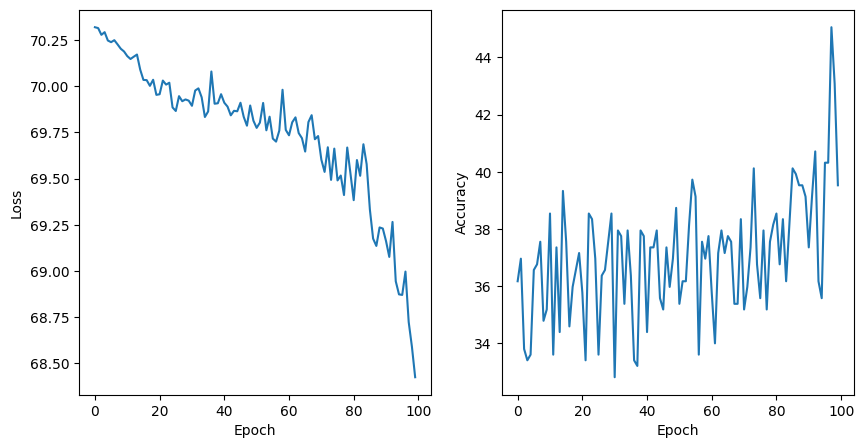

"\nnp.save('/content/drive/My Drive/Final_Turm_model_result_save/dilation_fpn_train_loss_100',train_loss)\nnp.save('/content/drive/My Drive/Final_Turm_model_result_save/dilation_fpn_test_accuracy_100',test_accuracy)\n"

In [19]:
import numpy as np
import matplotlib.pyplot as plt

_epochs = np.arange(0,epochs)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(_epochs,train_loss)
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(_epochs, test_accuracy)
plt.show()

train_loss=np.array(train_loss)
test_accuracy=np.array(test_accuracy)

"""
np.save('/content/drive/My Drive/Final_Turm_model_result_save/dilation_fpn_train_loss_100',train_loss)
np.save('/content/drive/My Drive/Final_Turm_model_result_save/dilation_fpn_test_accuracy_100',test_accuracy)
"""

In [21]:
np.save('C:/Users/drago/Learning_result/dilation_fpn_256_512_train_loss_100',train_loss)
np.save('C:/Users/drago/Learning_result/dilation_fpn_256_512_test_accuracy_100',test_accuracy)